
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



In [19]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo
# eventually include tensorboard

In [20]:
# ML resources:
import torch
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
from gensim.models import Word2Vec

#others:
import pandas as pd
import numpy as np


punctuation = [".",",","?", "!",";",":","-","_","(",")","[","]","{","}"]


Here we will extract the data:

In [21]:
emotions_emb = {}

data = load_dataset('daily_dialog')
X_train = data['train']['dialog']
Y_train = data['train']['emotion']

X_test = data['test']['dialog']
Y_test = data['test']['emotion']

X_val = data['validation']['dialog']
Y_val = data['validation']['emotion']

bagofwords = []
emotions = []

for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

In [22]:
def Preprocess_Data(X_,Y_): ## We do some simple prepocessing
  bagofwords = []
  emotions = []
  X = X_
  Y = Y_
  for i in range(len(X)):
    l1 = []
    l2 = []
    for j in range(len(X[i])):
      to_append = X[i][j].lower().split()
      l1.extend(to_append)
      l2.extend([Y[i][j]]*len(to_append))
      bagofwords.append(to_append)
    X[i] = l1
    Y[i] = l2

  for i in range(len(X)): ## remove puncuation
    to_remove = []
    for j in range(len(X[i])):
      if X[i][j] in punctuation:
        to_remove.append(j)
    for j in to_remove[::-1]:
      X[i].pop(j)
      Y[i].pop(j)
  for i in Y:
    for j in i:
      emotions.append(j)
  emotions = list(set(emotions))

  for lx,ly in zip(X,Y):
    assert(len(lx) == len(ly))
  return X_, Y_, bagofwords, emotions

X_train,Y_train, bagofwords1, emotions = Preprocess_Data(X_train,Y_train)
X_test,Y_test, bagofwords2, _ = Preprocess_Data(X_test,Y_test)
X_val,Y_val, bagofwords3, _ = Preprocess_Data(X_val,Y_val)



In [23]:
for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

print("train size: ",len(X_train))
print("test size: ",len(X_test))
print("validation size: ",len(X_val))
print("emotions: ",emotions)


train size:  11118
test size:  1000
validation size:  1000
emotions:  [0, 1, 2, 3, 4, 5, 6]


In [24]:
# Do that later on: So I can implement dataloaders and make the code cleaner
"""
data['train'] = data['train'].remove_columns(['id'])
data['test'] = data['test'].remove_columns(['id'])
data['validation'] = data['validation'].remove_columns(['id'])
"""

"\ndata['train'] = data['train'].remove_columns(['id'])\ndata['test'] = data['test'].remove_columns(['id'])\ndata['validation'] = data['validation'].remove_columns(['id'])\n"

Now we train w2v:

In [25]:
word_dim = 100
w2v = Word2Vec(sentences=bagofwords1, vector_size=word_dim, min_count=1)

print("vocabulary size: ",len(w2v.wv))

vocabulary size:  22075


In [26]:
if len(emotions_emb) > 0:
    pass
else:
  emotions_emb = {}

def encode_text(X):
  train_X = []
  words_list = []
  train_X_class = {}

  n = 0
  for dialog in X:
    seq = []
    for word in dialog:
      if word not in words_list:
        words_list.append(word)
      try:
        tens = torch.from_numpy(w2v.wv[word])
        tens = tens.type(torch.float32)
        seq.append(tens)
      except:
        tens = torch.rand(word_dim,dtype=torch.float32)
        seq.append(tens)
    train_X.append(seq)
  stoi = {word:i for i,word in enumerate(words_list)}
  itos = {i:word for i,word in enumerate(words_list)}
  X_utt = []
  for i,word in itos.items():
    tens = torch.zeros(len(words_list))
    tens[i] = 1
    train_X_class[word] = tens
  for dialog in X:
    le = []
    for word in dialog:
      le.append(train_X_class[word])
    X_utt.append(le)


  return train_X, stoi, itos, train_X_class,X_utt


## We do something similar to the emotions (but we initialized them randomly)
def encode_emotions(Y,emotions_emb,plot_=False):
  train_Y = []
  plot_data = {i:0 for i in emotions}
  if len(emotions_emb) == 0:
    for emotion in emotions:
      emotions_emb[emotion] = torch.rand(word_dim,dtype=torch.float32)

  for dialog in Y:
    l = []
    for em in dialog:
      l.append(emotions_emb[em])
    train_Y.append(l)
    if plot_:
      plot_data[em] += 1
  emotion_class = {}
  for i in emotions:
    ten = torch.zeros(len(emotions))
    ten[i] = 1
    emotion_class[i] = ten
  Y_emo = []
  for j in Y:
    t = []
    for k in j:
      t.append(emotion_class[k])
    Y_emo.append(t)
  if plot_:
    plt.plot(emotions,plot_data.values())
  return train_Y, Y_emo, emotion_class

def emotion_to_tensor(Y,emotion_class):
  emotion_tensor = []
  for dialog in Y:
    l = []
    for em in dialog:
      l.append(emotion_class[em])
    emotion_tensor.append(l)
  return torch.stack(emotion_tensor)

## SOME PLOTS ON THE DATA:


X_train1, stoi_train1, itos_train1, train_X_class,X_train_utt = encode_text(X_train)
Y_train1, Y_train_emo, emotion_class = encode_emotions(Y_train,emotions_emb)

X_test1, _, _, _ ,_ = encode_text(X_test)
Y_test1, Y_test_emo, emotion_class = encode_emotions(Y_test,emotions_emb)

X_val1, _, _, _,_ = encode_text(X_val)
Y_val1, Y_val_emo, _ = encode_emotions(Y_val,emotions_emb)


In [27]:
for l1,l2,l3 in zip(Y_train1,X_train1,Y_train_emo):
  assert(len(l1)==len(l2) and len(l1) == len(l3))
print(len(Y_train_emo[1]))
print(len(Y_train1[1]))
for i, vec in enumerate(train_X_class.values()):
  assert(i == torch.argmax(vec))
print(len(train_X_class))
a = torch.tensor([1,2,3,4])
print(torch.argmax(a))

46
46
22066
tensor(3)


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [32]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, n_emb_utt, n_emb_emo, emotions_size, vocab_size,device):
    super(SimpleModel,self).__init__()
    ## Decide size later!
    self.target_dev = device
    self.current_weight = 0
    self.decoder = nn.Linear(n_emb_utt,vocab_size)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(n_emb_utt,80)
    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(n_emb_utt,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final = nn.Linear(380, n_emb_utt)
    self.Linear_emo_final = nn.Linear(380, emotions_size)

    self.softmax = nn.Softmax(dim=0)

    self.Linear_hidden1 = [nn.Linear(80,80).to(device)]
    self.Linear_hidden2 = [nn.Linear(80,80).to(device)]
    self.Linear_hidden3 = [nn.Linear(80,80).to(device)]
    self.Linear_hidden4 = [nn.Linear(80,80).to(device)]

  def forward_w1(self,text_emb):
    x = self.Linear_utt1(text_emb)
    x = self.Linear_hidden1[self.current_weight](x)
    x = self.Linear_hidden2[self.current_weight](x)
    return x

  def forward_w2(self,emo_emb):
    x = self.Linear_emo1(emo_emb)
    x = self.Linear_hidden3[self.current_weight](x)
    x = self.Linear_hidden4[self.current_weight](x)
    return x

  def forward(self, text_emb, emo_emb):

    x = self.forward_w1(text_emb)
    y = self.forward_w2(emo_emb)

    z = torch.cat((x,y),-1) ## very simple
    z = self.Linear_fus(z)

    w = torch.cat((z,x),-1)

    pred_token = self.Linear_utt_final(w)
    pred_token = self.decoder(pred_token)
    pred_token = self.softmax(pred_token)

    v = torch.cat((z,y),-1)
    v = self.Linear_emo_final(v)

    pred_emotion = self.softmax(v)
    return pred_token, pred_emotion

  def predict_for_sequence(self,sequence_utt, sequence_emo):
    pt, pe = sequence_utt[0],sequence_emo[0]
    self.current_weight = 0
    loss = 0
    for j in emotions_emb.keys():
      emotions_emb[j] = emotions_emb[j].to(self.target_dev)
    for i in range(len(sequence_utt)):
      pt, pe = self.forward(pt,pe)
      pt = torch.argmax(pt).item()
      pe = torch.argmax(pe).item()
      if i <= len(sequence_utt)-2:
        pt = sequence_utt[i+1]
        pe = emotions_emb[pe] ## get embedding of emotion

      #else:
       # pt = train_X_class[pt] # ?
      #if i <= len(sequence_emo)-2:
      if i < len(self.Linear_hidden1)-1:
        self.current_weight += 1
      else:
        with torch.no_grad():
          self.update_text_w()
          self.update_emotions_w()
          self.current_weight += 1
    self.current_weight = 0
    return pt, pe

  def update_text_w(self):
    with torch.no_grad():
      new_layer1 = nn.Linear(80,80)
      new_layer2 = nn.Linear(80,80)
      new_weight1 = 0.2 * self.Linear_hidden1[-1].weight + 0.8 * self.Linear_hidden2[-1].weight
      new_weight2 = self.Linear_hidden2[-1].weight.clone()
      new_layer1.weight.copy_(new_weight1)
      new_layer2.weight.copy_(new_weight2)

      self.Linear_hidden1.append(new_layer1.to(self.target_dev))
      self.Linear_hidden2.append(new_layer2.to(self.target_dev))

  def update_emotions_w(self):
    with torch.no_grad():
      new_layer1 = nn.Linear(80,80)
      new_layer2 = nn.Linear(80,80)
      new_weight1 = 0.2 * self.Linear_hidden3[-1].weight + 0.8 * self.Linear_hidden4[-1].weight
      new_weight2 = self.Linear_hidden3[-1].weight.clone()
      new_layer1.weight.copy_(new_weight1)
      new_layer2.weight.copy_(new_weight2)

      self.Linear_hidden3.append(new_layer1.to(self.target_dev))
      self.Linear_hidden4.append(new_layer2.to(self.target_dev))


  def reset_hidden(self,device):
    with torch.no_grad():
      self.Linear_hidden1 = [nn.Linear(80,80).to(self.target_dev)]
      self.Linear_hidden2 = [nn.Linear(80,80).to(self.target_dev)]
      self.Linear_hidden3 = [nn.Linear(80,80).to(self.target_dev)]
      self.Linear_hidden4 = [nn.Linear(80,80).to(self.target_dev)]




In [33]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

def cluster_training(train_X,train_Y,train_Y_emo,train_X_utt,batch_size,device):
  i = 0
  j = 0
  batch_X = []
  batch_Y = []
  batch_emo = []
  batch_utt = []
  while True:
    found = False
    sbx = []
    sby = []
    sbe = []
    sbu = []
    lx,ly,le,lu = [], [], [], []
    while i < len(train_X):
      if j < len(train_X[i]) - 1:
        if len(lx) >= batch_size:
          sbx.append(lx.copy())
          sby.append(ly.copy())
          sbe.append(le.copy())
          sbu.append(lu.copy())

          lx = []
          ly = []
          le = []
          lu = []
        found = True
        lx.append(train_X[i][j])
        ly.append(train_Y[i][j])
        le.append(train_Y_emo[i][j+1])
        lu.append(train_X_utt[i][j+1])
      i += 1

    if found == False:
      break
    batch_X.append(sbx.copy())
    batch_Y.append(sby.copy())
    batch_emo.append(sbe.copy())
    batch_utt.append(sbu.copy())
    j += 1
    i = 0
  return batch_X, batch_Y, batch_emo, batch_utt

def optimize_batch(model,device,bX1,bY1,bEmo1,bUtt1,optimizer):
  loss_function = nn.CrossEntropyLoss()
  loss = 0
  optimizer.zero_grad()
  model.zero_grad()
  for bX, bY, bEmo, bUtt in zip(bX1, bY1, bEmo1,bUtt1):
    if len(bX) <= 1:
      continue
    utts = torch.stack(bX[:-1]).to(device)
    emos = torch.stack(bY[:-1]).to(device)
    next_emos = torch.stack(bEmo[1:]).to(device)
    next_tokens = torch.stack(bUtt[1:]).to(device)
    pred_token, pred_emotion = model.forward(utts,emos)
    pred_token_2 = []
    #for ten in pred_token:
     # ten1 = itos_train1[torch.argmax(ten).item()]
      #pred_token_2.append(train_X_class[ten1])
   # pred_token_2 = torch.stack(pred_token_2).to(device)
    loss += loss_function(pred_emotion, next_emos)
    #loss += loss_function(pred_token_2, next_tokens)
  if type(loss) in [int, float]:
    return loss
  loss.backward()

  optimizer.step()

  return loss.item()


def train(model, epochs, device,train_X, train_Y, train_Y_emo,train_X_utt,batch_size = 100):
  optimizer = optim.Adam(model.parameters())
  model.train()
  model = model.to(device)
  losses = []
  batch_X, batch_Y, batch_emo,batch_utt = cluster_training(train_X,train_Y,train_Y_emo,train_X_utt,batch_size,device)
  for i in emotion_class.keys():
    emotion_class[i] = emotion_class[i].to(device)
  for i in train_X_class.keys():
    train_X_class[i].to(device)


  for epoch in range(epochs):
    optimizer.zero_grad()
    model.zero_grad()
    print(f"Epoch {epoch+1}/{epochs}")
    x_axis = []
    loss_batch = 0
    model.current_weight = 0

    for bX1,bY1,bEmo1,bUtt1 in tqdm(zip(batch_X,batch_Y,batch_emo,batch_utt), total = len(batch_X)):
      loss_batch += optimize_batch(model,device,bX1,bY1,bEmo1,bUtt1,optimizer)
      if epoch == 0:
        with torch.no_grad():
          model.update_text_w()
          model.update_emotions_w()
      model.current_weight += 1

    loss_batch = loss_batch/(len(batch_X))
    losses.append(loss_batch)
    print(f"loss: ",loss_batch)
  return losses


In [34]:
device = activate_gpu()
model = SimpleModel(word_dim,word_dim,len(emotions),len(train_X_class),device)
print(device)

DEVICE =  Tesla T4
cuda


Epoch 1/5


  0%|          | 0/772 [00:00<?, ?it/s]

loss:  24.394400934172417
Epoch 2/5


  0%|          | 0/772 [00:00<?, ?it/s]

loss:  24.394248552736222
Epoch 3/5


  0%|          | 0/772 [00:00<?, ?it/s]

loss:  24.39388220097117
Epoch 4/5


  0%|          | 0/772 [00:00<?, ?it/s]

loss:  24.39382614913382
Epoch 5/5


  0%|          | 0/772 [00:00<?, ?it/s]

loss:  24.393741835738712


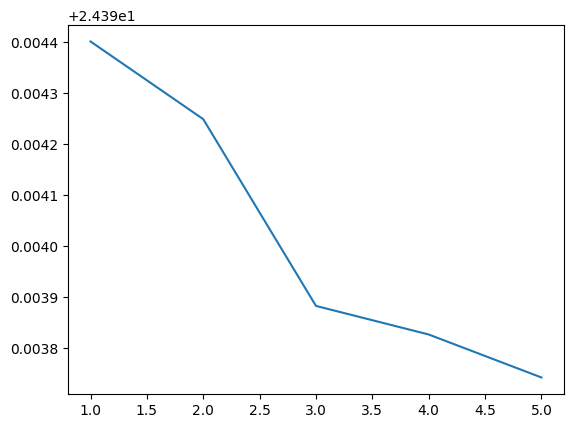

In [35]:
epochs = 5

losses = train(model,epochs,device,X_train1,Y_train1,Y_train_emo,X_train_utt)
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [36]:
def compute_test_loss(model,X,Y,Y_emo,loss_fn,device):
  model.eval()
  losses = []
  prec = 0
  total = 0
  for i in range(len(X)):
    for k in range(len(X[i])):
      X[i][k] = X[i][k].to(device)
      Y[i][k] = Y[i][k].to(device)
      Y_emo[i][k] = Y_emo[i][k].to(device)
  for j in emotion_class.keys():
    emotion_class[j] = emotion_class[j].to(device)
  for seq_X, seq_Y, seq_emo in zip(X[:-1],Y[:-1],Y_emo[1:]):
    loss = 0
    pt,pe = model.predict_for_sequence(seq_X,seq_Y)
    if pe == torch.argmax(seq_emo[-1]).item():
      prec += 1
    loss += loss_fn(emotion_class[pe],seq_emo[-1])
    total +=1
    losses.append(loss.item())
  print("precision: ", prec/total)
  print("The loss on the test set is: ", np.mean(losses))

compute_test_loss(model,X_test1,Y_test1,Y_test_emo,nn.CrossEntropyLoss(),device)
compute_test_loss(model,X_val1,Y_val1,Y_val_emo,nn.CrossEntropyLoss(),device)


precision:  0.26326326326326327
The loss on the test set is:  1.902158937893353
precision:  0.24024024024024024
The loss on the test set is:  1.925181960916376
